In [1]:
# brew install graphviz
# pip install pygraphviz --install-option="--include-path=/usr/include/graphviz" --install-option="--library-path=/usr/lib/graphviz/"
# from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
import operator
import math
import random

import numpy as np
from sklearn.metrics import mean_squared_error

# display
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [3]:
def hidden_function(x):
    #return x**4 - x**3 - x**2 - x
    # return np.cos(2*np.pi*x)
    # return np.sin(x)

    # return np.exp(-x) * np.cos(2*np.pi*x)
    
    return np.sin(x) + 1/2 * np.sin(2*x) + 1/4 * np.sin(4*x) + 1/8 * np.sin(8*x)

def hidden_function_bbox():
    #points=[x for x in range(-10,10)]
    points = np.arange(-5, 5, 0.1)
    return points

def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evaluate the mean squared error between the expression and the real function
    y_true = list(map(lambda x: hidden_function(x), points))
    y_pred = list(map(lambda x: func(x), points))
    
    # current_population = toolbox.get_current_population()
    # for each agent: 
    # d = number of all nodes
    # d = maximum depth
    # d_fitness = []
    # d_fitness.append = e_current / e_agent + d_current / d_agent
    # final_fiteness = np.mode(d_fitness)
    
    return mean_squared_error(y_true, y_pred),
    
# sqerrors = ((func(x) - hidden_function(x))**2 for x in points)   
# return math.fsum(sqerrors) / len(points),

In [4]:
# https://github.com/DEAP/deap/blob/04c09bf287256a337bc1be0f87c3eadaefd910ce/deap/algorithms.py
def eaSimpleV2(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm reproduce the simplest evolutionary algorithm as
    presented in chapter 7 of [Back2000]_.
    :param population: A list of individuals.
    :param toolbox: A :class:`~deap.base.Toolbox` that contains the evolution
                    operators.
    :param cxpb: The probability of mating two individuals.
    :param mutpb: The probability of mutating an individual.
    :param ngen: The number of generation.
    :param stats: A :class:`~deap.tools.Statistics` object that is updated
                  inplace, optional.
    :param halloffame: A :class:`~deap.tools.HallOfFame` object that will
                       contain the best individuals, optional.
    :param verbose: Whether or not to log the statistics.
    :returns: The final population
    :returns: A class:`~deap.tools.Logbook` with the statistics of the
              evolution
    The algorithm takes in a population and evolves it in place using the
    :meth:`varAnd` method. It returns the optimized population and a
    :class:`~deap.tools.Logbook` with the statistics of the evolution. The
    logbook will contain the generation number, the number of evalutions for
    each generation and the statistics if a :class:`~deap.tools.Statistics` is
    given as argument. The *cxpb* and *mutpb* arguments are passed to the
    :func:`varAnd` function. The pseudocode goes as follow ::
        evaluate(population)
        for g in range(ngen):
            population = select(population, len(population))
            offspring = varAnd(population, toolbox, cxpb, mutpb)
            evaluate(offspring)
            population = offspring
    As stated in the pseudocode above, the algorithm goes as follow. First, it
    evaluates the individuals with an invalid fitness. Second, it enters the
    generational loop where the selection procedure is applied to entirely
    replace the parental population. The 1:1 replacement ratio of this
    algorithm **requires** the selection procedure to be stochastic and to
    select multiple times the same individual, for example,
    :func:`~deap.tools.selTournament` and :func:`~deap.tools.selRoulette`.
    Third, it applies the :func:`varAnd` function to produce the next
    generation population. Fourth, it evaluates the new individuals and
    compute the statistics on this population. Finally, when *ngen*
    generations are done, the algorithm returns a tuple with the final
    population and a :class:`~deap.tools.Logbook` of the evolution.
    .. note::
        Using a non-stochastic selection method will result in no selection as
        the operator selects *n* individuals from a pool of *n*.
    This function expects the :meth:`toolbox.mate`, :meth:`toolbox.mutate`,
    :meth:`toolbox.select` and :meth:`toolbox.evaluate` aliases to be
    registered in the toolbox.
    .. [Back2000] Back, Fogel and Michalewicz, "Evolutionary Computation 1 :
       Basic Algorithms and Operators", 2000.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [5]:
# Define new functions
def protectedDiv(left, right):
    if right == 0:
        return 1
    if left == 0:
        return 0
    
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1))
pset.addTerminal(np.pi)
# pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0='x')

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg, points=hidden_function_bbox())
toolbox.register("select", tools.selTournament, tournsize=3)
# increase probability of small trees (bloat)
# https://deap.readthedocs.io/en/master/api/tools.html?highlight=selDoubleTournament#deap.tools.selDoubleTournament
#toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1, fitness_first=True)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# ----------------------
# stats
history = tools.History()
toolbox.decorate("mate", history.decorator)
toolbox.decorate("mutate", history.decorator)

# limit the size of trees (bloat)
# https://deap.readthedocs.io/en/master/api/tools.html?highlight=bloat#deap.gp.staticLimit
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
# ----------------------


def main():
    random.seed(318)

    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

#     pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 2, stats=mstats,
#                                    halloffame=hof, verbose=False)
    
    pop, log = eaSimpleV2(pop, toolbox, 0.5, 0.1, 20, stats=mstats,
                                   halloffame=hof, verbose=False)
    
    return pop, log, hof

pop, log, hof = main()

In [6]:
alfa = hof[0]
alfa_func = toolbox.compile(expr=alfa)
#print(log.chapters["fitness"])

### Display learning process

In [7]:
def plot_learning(logbook):
    gen = logbook.select("gen")
    fit_mins = logbook.chapters["fitness"].select("min")
    size_avgs = logbook.chapters["size"].select("avg")

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Min Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Size")
    ax2.set_ylabel("Size", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    plt.show()
    
    
def plot_chapter(logbook, chapter="fitness"):
    gen = logbook.select("gen")
    avg, min_, max_ = logbook.chapters[chapter].select("avg", "min", "max")
    
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel(chapter)
    plt.legend(loc="lower right")
    plt.show()

def show_history(alfa, history):
    h = history.getGenealogy(alfa, max_depth=5)
    graph = nx.DiGraph(h)
    graph = graph.reverse()     # Make the grah top-down
    colors = [toolbox.evaluate(history.genealogy_history[i])[0] for i in graph]
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos, node_color=colors)
    # cb = plt.colorbar()
    # cb.set_label("Error")
    plt.show()

def explain_me(item):
    print('Final error:', item.fitness)
    print('Size:', len(item))
    print()
    print(str(item))
    nodes, edges, labels = gp.graph(item)

    ### Graphviz Section ###
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    pos = graphviz_layout(g, prog="dot")

    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edges(g, pos)
    nx.draw_networkx_labels(g, pos, labels)
    plt.show()

Final error: (0.02589012248141371,)
Size: 18

sin(add(x, sin(sin(sin(sin(sin(add(x, sin(add(x, add(x, sin(sin(x)))))))))))))


/Users/odats/Documents/Projects/embrio/embrio_env_office/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


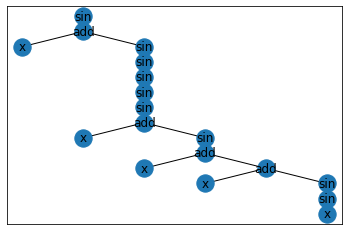

/Users/odats/Documents/Projects/embrio/embrio_env_office/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/odats/Documents/Projects/embrio/embrio_env_office/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


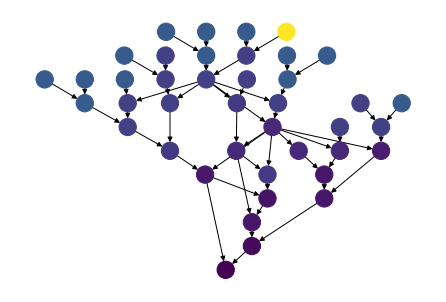

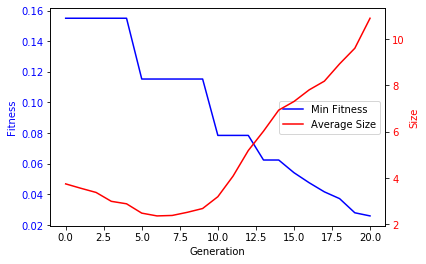

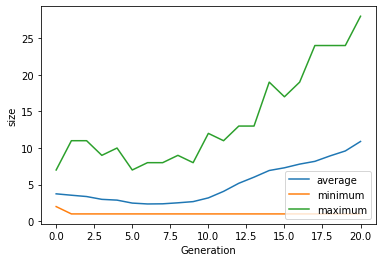

In [8]:
explain_me(alfa)
show_history(alfa, history)
plot_learning(log)
plot_chapter(log, "size")

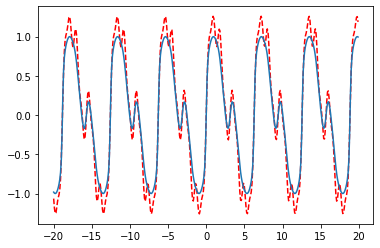

In [9]:
points = hidden_function_bbox()

points= np.arange(-20, 20, 0.1)
# np.exp(-t) * np.cos(2*np.pi*t)
plt.plot(points, [hidden_function(x) for x in points], 'r--')
plt.plot(points, [alfa_func(x) for x in points])
plt.show()

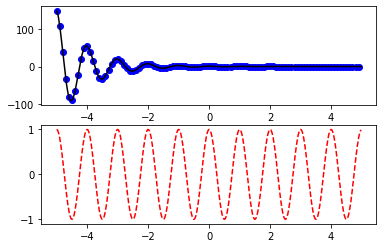

In [10]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

t1 = np.arange(-5, 5.0, 0.1)
t2 = np.arange(-5, 5.0, 0.02)

plt.figure(1)
plt.subplot(211)
plt.plot(t1, f(t1), 'bo', t2, f(t2), 'k')

plt.subplot(212)
plt.plot(t2, np.cos(2*np.pi*t2), 'r--')
plt.show()